##Add image augmentation

This notebook is to create a folder with augmented images of the same structure as the stage1_train.

The augmentation is generated by imgaug python library.



In [183]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
from imgaug import augmenters as iaa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

In [184]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 16, 32, 64, 256)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING   

In [185]:
TRAIN_PATH = './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [188]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids
        

In [ ]:

category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
#print((cate['foreground'] == 'white') & (cate['background'] == 'black')) 
white_black = cate.loc[(cate['foreground'] == 'white') \
                       & (cate['background'] == 'black'),'filename'].tolist()
purple_yellow = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'yellow') ,'filename'].tolist()
purple_white = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'white') ,'filename'].tolist()
purple_purple = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'purple') ,'filename'].tolist()
black_white = cate.loc[(cate['foreground'] == 'black') \
                       & (cate['background'] == 'white') ,'filename'].tolist()

print("number of white_black image: %d" %len(white_black))
print("number of purple_yellow image: %d" %len(purple_yellow))
print("number of purple_white image: %d" %len(purple_white))
print("number of purple_purple image: %d" %len(purple_purple))
print("number of black_white image: %d" %len(black_white))


In [190]:
train_index = [n for i, n in enumerate(train_ids) \
               if n+".png" in white_black[:int(len(white_black)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) \
             if n+".png" in white_black[int(len(white_black)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_yellow[:int(len(purple_yellow)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_yellow[int(len(purple_yellow)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_white[:int(len(purple_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_white[int(len(purple_white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_purple[:int(len(purple_purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_purple[int(len(purple_purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in black_white[:int(len(black_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in black_white[int(len(black_white)*0.8):]]
print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 531
length of validation set: 133
False


In [191]:
#load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

###Create sequential image augmentation pipeline.

Can also use iaa.SomeOf, OneOf, Sometimes to add randomness to the image augmentation pipeline (see the API).

In [159]:

import imgaug as ia
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    #iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    
    iaa.GaussianBlur(sigma=(0, 1)),
    # Strengthen or weaken the contrast in each image.
    #iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order
seq_det = seq.to_deterministic()




Create a folder to store the augmented images

In [270]:
os.system("mkdir ./input/test")

256

In [271]:
def save_aug(fig_name, batch_name):
    image_id = train_index.index(fig_name)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    images_aug = seq_det.augment_image(image)
    width = image.shape[1]
    height = image.shape[0]
    os.system("mkdir ./input/" + batch_name + "/" + fig_name + batch_name)
    os.system("mkdir ./input/" + batch_name + "/" + fig_name + batch_name) 
    os.system("mkdir ./input/" + batch_name + "/" + fig_name + batch_name + "/images/") 
    os.system("mkdir ./input/" + batch_name + "/" + fig_name + batch_name + "/masks/") 
    image_path = "./input/" + batch_name + "/" + fig_name + batch_name + "/images/" +\
                fig_name + batch_name + ".png"
    skimage.io.imsave(image_path, images_aug)
    mask_path = "./input/" + batch_name + "/" + fig_name + batch_name + "/masks/" +\
                fig_name + batch_name
    for i in range(mask.shape[2]):        
        masks_aug = seq_det.augment_image(mask[:,:,i]).astype(int)
        if masks_aug.sum() != 0: #if this slice does not have positive mask, ignore this slice
            masks_aug[np.where(masks_aug==1)] = 255
            skimage.io.imsave(mask_path + str(i) + ".png", masks_aug)
        else:
            continue

Here only tested one image from the stage1_train folder, can use a loop to create augmented image for each image in this folder.

In [256]:
import warnings #too much warnings about saving low contrast images
warnings.filterwarnings('ignore')
save_aug(train_index[1], 'test') 

In [273]:
Aug_PATH = "./input/test/"
Aug_index = [train_index[1] + "test"] # this index has to be a list 
dataset_aug = NucleiDataset() #add augmented images by calling NucleiDataset
dataset_aug.load_nuclei(Aug_PATH, Aug_index)
dataset_aug.prepare()


The original image

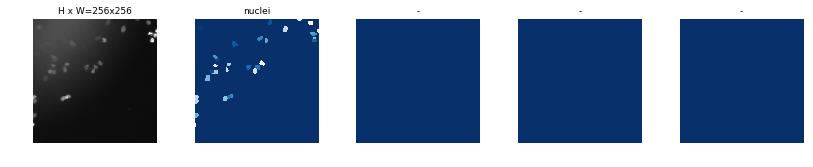

In [260]:
image = dataset_train.load_image(1)
mask, class_ids = dataset_train.load_mask(1)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


The agumented image

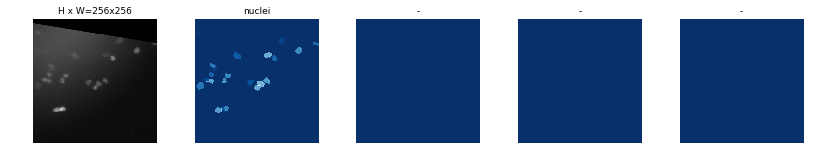

In [274]:
image = dataset_aug.load_image(0)
mask, class_ids = dataset_aug.load_mask(0)
visualize.display_top_masks(image, mask, class_ids, dataset_aug.class_names)